In [2]:
import os
from PIL import Image
import cv2
import numpy as np
import pandas as pd
from ast import literal_eval

import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.patches as patches
from tqdm.notebook import tqdm

In [3]:
BASE_DIR = os.path.dirname(os.path.abspath("__file__"))
DATA_DIR = os.path.join(BASE_DIR, "data")
IMG_DIR = os.path.join(DATA_DIR, "images")
MPII_annotation = os.path.join(DATA_DIR, "updated_mpii_dataset.csv")
TEMP_DIMENSION = (150, 150)
OUTPUT_DIMENSION = (320, 320)

In [4]:
pd_data = pd.read_csv(MPII_annotation)
for i in pd_data.columns[1:-7]:
    pd_data[i] = pd_data[i].apply(literal_eval)
pd_data

,image_name,left_shoulder,right_shoulder,left_elbow,right_elbow,left_wrist,right_wrist,left_hip,right_hip,left_knee,right_knee,left_ankle,right_ankle,pelvis,thorax,upper_neck,head_top,scale,activity,category
0,015601864.jpg,"(692, 185)","(601, 167)","(693, 240)","(553, 161)","(688, 313)","(606, 217)","(647, 188)","(573, 185)","(661, 221)","(616, 269)","(656, 231)","(620, 394)","(610, 187)","(647, 176)","(637.0201, 189.8183)","(695.9799, 108.1817)",3.021046,curling,sports
1,015599452.jpg,"(719, 299)","(647, 281)","(711, 516)","(555, 410)","(545, 466)","(563, 296)","(720, 593)","(806, 543)","(-1, -1)","(-1, -1)","(-1, -1)","(-1, -1)","(763, 568)","(683, 290)","(682.0, 256.0)","(676.0, 68.0)",5.641276,curling,sports
2,005808361.jpg,"(1067, 253)","(902, 253)","(1167, 353)","(798, 340)","(1142, 478)","(869, 214)","(1040, 454)","(908, 438)","(906, 528)","(816, 510)","(883, 707)","(804, 711)","(974, 446)","(985, 253)","(982.7591, 235.9694)","(962.2409, 80.0306)",4.718488,curling,sports
3,086617615.jpg,"(314, 264)","(244, 261)","(327, 320)","(260, 335)","(362, 346)","(328, 354)","(294, 342)","(201, 340)","(335, 370)","(305, 375)","(331, 455)","(301, 461)","(248, 341)","(279, 263)","(277.021, 268.7786)","(305.979, 184.2214)",2.681349,curling,sports
4,060111501.jpg,"(923, 123)","(792, 147)","(995, 163)","(754, 247)","(961, 223)","(772, 294)","(943, 226)","(865, 248)","(948, 290)","(896, 318)","(881, 349)","(980, 322)","(904, 237)","(858, 135)","(871.1877, 180.4244)","(835.8123, 58.5756)",3.806403,curling,sports
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17367,033474347.jpg,"(663, 223)","(704, 214)","(674, 286)","(726, 260)","(631, 260)","(693, 243)","(742, 303)","(779, 296)","(706, 386)","(815, 380)","(739, 468)","(876, 461)","(761, 300)","(684, 219)","(671.7848, 204.2324)","(629.2152, 152.7676)",2.003677,pushing car,transportation
17368,082650067.jpg,"(729, 220)","(821, 204)","(704, 332)","(864, 273)","(675, 269)","(815, 236)","(831, 337)","(903, 328)","(811, 504)","(950, 504)","(853, 637)","(1038, 656)","(867, 333)","(775, 212)","(762.9653, 196.7913)","(696.0347, 112.2087)",3.235820,pushing car,transportation
17369,072772110.jpg,"(490, 378)","(572, 377)","(470, 411)","(565, 393)","(461, 414)","(558, 411)","(511, 458)","(553, 452)","(529, 536)","(558, 539)","(541, 610)","(562, 617)","(532, 455)","(531, 378)","(528.9869, 352.8365)","(525.0131, 303.1635)",1.494952,pushing car,transportation
17370,039361034.jpg,"(466, 251)","(441, 253)","(436, 293)","(404, 288)","(410, 325)","(378, 311)","(540, 280)","(510, 278)","(558, 331)","(466, 322)","(596, 368)","(496, 377)","(525, 279)","(454, 252)","(451.3169, 251.4431)","(403.6831, 241.5569)",1.459468,pushing car,transportation


In [5]:
def get_line_segments(x):
    groups = [
        ["left_shoulder", "left_elbow"],
        ["left_elbow", "left_wrist"],
        ["right_shoulder", "right_elbow"],
        ["right_elbow", "right_wrist"],
        ["left_ankle", "left_knee"],
        ["left_knee", "left_hip"],
        ["right_ankle", "right_knee"],
        ["right_knee", "right_hip"],
        ["left_shoulder", "right_shoulder"],
        ["left_hip", "right_hip"]
    ]
    
    lines = []
    for i in groups:
        if x[i[0]][0] != -1 and x[i[1]][0] != -1:
            lines.append([x[i[0]], x[i[1]]])
    if x[groups[-2][0]][0] != -1 and x[groups[-2][1]][0] != -1:
        if x[groups[-1][0]][0] != -1 and x[groups[-1][1]][0] != -1:
            lines.append([
                [(x[groups[-2][0]][0] + x[groups[-2][1]][0])/2, (x[groups[-2][0]][1] + x[groups[-2][1]][1])/2],
                [(x[groups[-1][0]][0] + x[groups[-1][1]][0])/2, (x[groups[-1][0]][1] + x[groups[-1][1]][1])/2]
            ])
    return lines

In [6]:
def adjust_offset(x, coordinates="x", offset=0):
    if coordinates == "x":
        if x[0] != -1:
            x = (x[0] - offset, x[1])
    else:
        if x[0] != -1:
            x = (x[0], x[1] - offset)
    return x

In [7]:
def resize(x, scale):
    if x[0] != -1:
        x = (int(x[0]/scale), int(x[1]/scale))
    return x

In [8]:
def save_plot(image:"numpy.ndarray", pose, img_name, channel="gray", ratio:int=5):
    height, width = image.shape[0], image.shape[1]
    aspect_ratio = float(width) / height
    fig, ax = plt.subplots(figsize=(ratio*aspect_ratio, ratio))
    fig.tight_layout(pad=0)
    ax.margins(0)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    plt.axis('off')
    cmap = channel if channel == "gray" else "viridis"
    ax.imshow(image, cmap=cmap)
    line_segments = LineCollection([], linewidths=(3), linestyle='solid', color='red')
    ax.add_collection(line_segments)
    temp = get_line_segments(pose)
    dots = list(set((j[0], j[1]) for i in temp for j in i))
    line_segments.set_segments(temp)
    for i in dots:
        plt.scatter(i[0], i[1], s=20, zorder=3, color='white')
    plt.savefig(img_name, bbox_inches='tight', pad_inches=0)
    plt.close(fig)

In [9]:
def read_image(img_loc: str, channel: "gray or rgb"="gray"):
    channel = channel.lower()
    assert channel in ["gray", "rgb"]
    image = cv2.imread(img_loc)
    if channel == "rgb":
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    else:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = np.expand_dims(image, axis=-1)
        image = np.repeat(image, 3, axis=-1)
        height, width, channel = image.shape
    return image

In [10]:
def display_image(image: "image_loc or numpy.ndarray", ratio:int=5, **kwargs):
    assert isinstance(image, str) or isinstance(image, np.ndarray)
    channel = kwargs.get("channel", "gray")
    if isinstance(image, str):
        image = read_image(image, channel)
#     else:
#         if channel == "gray": image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    assert isinstance(image, np.ndarray)
    height, width = image.shape[0], image.shape[1]
    aspect_ratio = float(width) / height
    fig, ax = plt.subplots(figsize=(ratio*aspect_ratio, ratio))
    fig.tight_layout(pad=0)
    ax.margins(0)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    plt.axis('off')
    cmap = channel if channel == "gray" else "viridis"
    ax.imshow(image, cmap=cmap)
    return ax

In [11]:
def display_image_with_pose(image: "image_loc or numpy.ndarray", pose: "pandas.core.frame.DataFrame", ratio:int=5, **kwargs):
    ax = display_image(image, ratio, **kwargs)
    line_segments = LineCollection([], linewidths=(3), linestyle='solid', color='red')
    ax.add_collection(line_segments)
    temp = get_line_segments(pose)
#     temp = pose.apply(lambda x: get_line_segments(x), axis=1).to_list()[0]
    dots = list(set((j[0], j[1]) for i in temp for j in i))
    line_segments.set_segments(temp)
    for i in dots:
        plt.scatter(i[0], i[1], s=20, zorder=3, color='white')
    return ax

### For image cropping, we are always cropping along the width of the image and not the height

In [12]:
def crop_image(image: "image_loc or numpy.ndarray", pose: "pandas.core.frame.DataFrame", **kwargs):
    assert isinstance(image, str) or isinstance(image, np.ndarray)
    channel = kwargs.get("channel", "gray")
    if isinstance(image, str):
        image = read_image(image, channel)
#     else:
#         if channel == "gray": image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    width, height = image.shape[1], image.shape[0]
    # Make sure that the image width is at least equal to image height, else add padding to the right
    if width < height:
        image = cv2.copyMakeBorder(image, 0, 0, 0, height - width, cv2.BORDER_CONSTANT, value=[0, 0, 0])
    min_x, min_y, max_x, max_y = width, height, 0, 0
    # for i in pose.values[0][1:-7]:
    for i in pose[1:-7]:
        if i[0] != -1:
            min_x, min_y = min(min_x, i[0]), min(min_y, i[1])
            max_x, max_y = max(max_x, i[0]), max(max_y, i[1])
    center_x, center_y = int((min_x+max_x)/2), int((min_y+max_y)/2)
    annot_width, annot_height = max_x - min_x, max_y - min_y
    # If the annotation height or width is greater than image height or width,
    # add padding to the image and crop afterwards
    if annot_height > width:
        padding = (annot_height - width)//2
        image = cv2.copyMakeBorder(image, 0, 0, padding, annot_height - width - padding, cv2.BORDER_CONSTANT, value=[0, 0, 0])
        pose[1:-7] = pose[1:-7].apply(adjust_offset, coordinates="x", offset=-padding)
    if annot_width > height:
        padding = (annot_width - height)//2
        image = cv2.copyMakeBorder(image, padding, annot_width - height - padding, 0, 0, cv2.BORDER_CONSTANT, value=[0, 0, 0])
#         pose = pose.apply(lambda x: adjust_offset(x, coordinates="y", offset=-padding), axis=1)
        pose[1:-7] = pose[1:-7].apply(adjust_offset, coordinates="y", offset=-padding)
    width, height = image.shape[1], image.shape[0]
    if height < width:
        # height stays the same, crop the width
        offset = max(0, center_x - int(height/2))
        adj_coor = "x"
        image = image[:, offset: offset + height]
        pose[1:-7] = pose[1:-7].apply(adjust_offset, coordinates=adj_coor, offset=offset)
#         pose = pose.apply(lambda x: adjust_offset(x, coordinates=adj_coor, offset=offset), axis=1)
    if width < height:
        # width stays the same, crop the height
        offset = max(0, center_y - int(width/2))
        adj_coor = "y"
        image = image[offset: offset + width, :]
#         pose = pose.apply(lambda x: adjust_offset(x, coordinates=adj_coor, offset=offset), axis=1)
        pose[1:-7] = pose[1:-7].apply(adjust_offset, coordinates=adj_coor, offset=offset)
    if image.shape[1] < image.shape[0]: # pad to the right
        image = cv2.copyMakeBorder(image, 0, 0, 0, image.shape[0] - image.shape[1], cv2.BORDER_CONSTANT, value=[0, 0, 0])
    if image.shape[0] < image.shape[1]: # pad to the bottom
        image = cv2.copyMakeBorder(image, 0, image.shape[1] - image.shape[0], 0, 0, cv2.BORDER_CONSTANT, value=[0, 0, 0])
    if kwargs.get("display"):
        ax = display_image(image, **kwargs)
        line_segments = LineCollection([], linewidths=(3), linestyle='solid', color='red')
        ax.add_collection(line_segments)
        temp = pose.copy()
        temp[1:-7] = temp[1:-7].apply(get_line_segments)
        temp = temp.to_list()[0]
#         temp = pose.apply(lambda x: get_line_segments(x), axis=1).to_list()[0]
        dots = list(set((j[0], j[1]) for i in temp for j in i))
        line_segments.set_segments(temp)
        for i in dots:
            plt.scatter(i[0], i[1], s=20, zorder=3, color='white')
    return image, pose

In [13]:
def resize_image(image: "image_loc or numpy.ndarray", pose: "pandas.core.frame.DataFrame", dimensions: tuple, **kwargs):
    scale = image.shape[0]/dimensions[0]
    assert isinstance(dimensions, tuple) and len(dimensions) == 2
    image = cv2.resize(image, dimensions, interpolation=cv2.INTER_AREA)
    pose[1:-7] = pose[1:-7].apply(resize, scale=scale)
#     pose = pose.apply(lambda x: resize(x, scale=scale), axis=1)
    return image, pose

In [14]:
def augment(x, pbar, channel="gray", display=False):
    assert channel in ["gray", "rgb"]
    img_loc = os.path.join(IMG_DIR, x['image_name'])
    image = read_image(img_loc, channel=channel)
    if display:
        display_image(image)
        print("Original shape:", image.shape)
    image, x = crop_image(image, pose=x, channel=channel)
    if display:
        display_image(image)
        print("After cropping:", image.shape)
    image, x = resize_image(image, pose=x, dimensions=TEMP_DIMENSION)
    if display:
        display_image(image)
        print("After resizing to lower dimension:", image.shape)
    image, x = resize_image(image, pose=x, dimensions=OUTPUT_DIMENSION)
    if display:
        display_image(image)
        print("After resizing to higher dimension:", image.shape)
    new_loc = "{0}/updated/{1}/{2}".format("/".join(img_loc.split("/")[:-2]), x.name//100, img_loc.split("/")[-1])
    temp_dir = "/".join(new_loc.split("/")[:-1])
    if not os.path.exists(temp_dir): os.makedirs(temp_dir)
    if not os.path.exists(temp_dir.replace("updated", "confirmation")): os.makedirs(temp_dir.replace("updated", "confirmation"))
    if display:
        display_image_with_pose(image, x, channel="rgb")
    save_plot(image, x, new_loc.replace("updated", "confirmation"), channel="gray")
#     plt_img = plt.savefig(new_loc.replace("updated", "confirmation"), bbox_inches='tight', pad_inches=0)
    if channel == "rgb":
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    cv2.imwrite(new_loc, image)
    pbar.update(1)
    return x

In [15]:
# idx = 12310
# img_loc = os.path.join(IMG_DIR, pd_data.iloc[idx]['image_name'])
# print(img_loc, "\n")
# temp = pd_data.iloc[[idx]]

In [16]:
# idx = np.random.choice(np.arange(pd_data.shape[0]), 10, replace=False)

Applying augmentation:   0%|          | 0/17372 [00:00<?, ?it/s]

KeyboardInterrupt: 

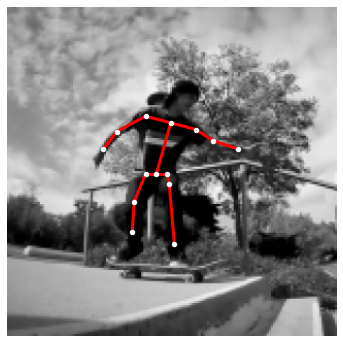

In [17]:
cutoff=2000
pbar = tqdm(total=pd_data.shape[0], desc="Applying augmentation: ")
for i in range(pd_data.shape[0]//cutoff + 1):
    if not os.path.exists(MPII_annotation.replace("updated", "{0}_model_ready".format(i))):
        temp = pd_data.copy().iloc[i*cutoff:(i+1)*cutoff].apply(lambda x: augment(x, pbar, display=False), axis=1)
        temp.to_csv(MPII_annotation.replace("updated", "{0}_model_ready".format(i)), index=False)
    else:
        pbar.update(cutoff)
pbar.close()

In [20]:
temp, files = [], []
for i in os.listdir(DATA_DIR):
    if "model_ready" in i:
        file = os.path.join(DATA_DIR, i)
        files.append(file)        
        temp.append(pd.read_csv(file))

In [34]:
combined = pd.concat(temp).reset_index(drop=True)

In [35]:
combined.to_csv("final_model_ready_dataset.csv", index=False)

In [36]:
set(pd_data['image_name']) - set(combined['image_name'])

set()

In [37]:
set(combined['image_name']) - set(pd_data['image_name'])

set()

In [25]:
for file in files:
    if os.path.exists(file):
        os.remove(file)